In [5]:
!pip install scikit-fuzzy

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from sklearn.metrics import jaccard_score

In [7]:
# Load image
image = cv2.imread("/kaggle/input/datasets/jeetblahiri/bccd-dataset-with-mask/BCCD Dataset with mask/train/original/002f20ad-2ace-499c-9335-c9080bc3e6b5.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize for faster processing
image = cv2.resize(image, (256, 256))

# Blur to remove noise
blur = cv2.GaussianBlur(image, (5,5), 0)

# Reshape for clustering
pixel_values = blur.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

In [8]:
k = 3  # nucleus, cytoplasm, background

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(pixel_values)

# Convert labels back to image
segmented_kmeans = labels.reshape((256, 256))

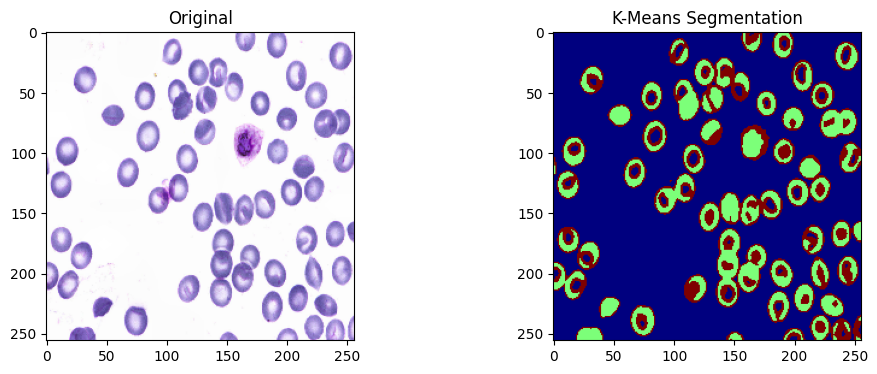

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(segmented_kmeans, cmap='jet')
plt.title("K-Means Segmentation")
plt.show()

In [10]:
# Transpose data for FCM
pixel_values_T = pixel_values.T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    pixel_values_T,
    c=3,
    m=2,
    error=0.005,
    maxiter=1000
)

# Get highest membership
fcm_labels = np.argmax(u, axis=0)

segmented_fcm = fcm_labels.reshape((256,256))

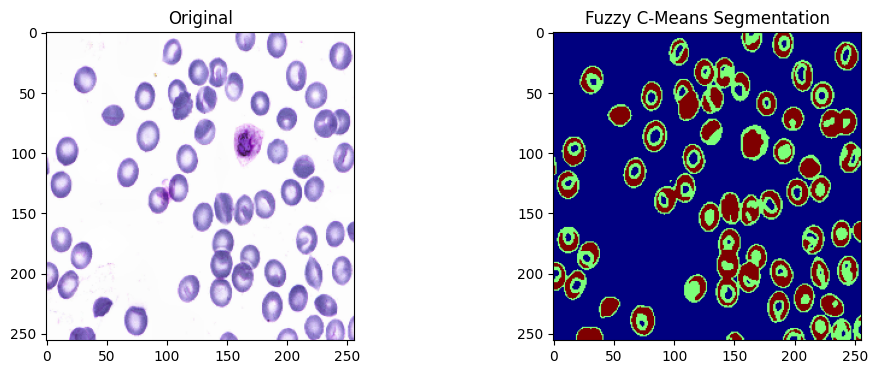

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(segmented_fcm, cmap='jet')
plt.title("Fuzzy C-Means Segmentation")
plt.show()

In [12]:
# Find cluster centers brightness
centers = kmeans.cluster_centers_
brightness = np.sum(centers, axis=1)

nucleus_cluster = np.argmin(brightness)

nucleus_mask_kmeans = (segmented_kmeans == nucleus_cluster).astype(np.uint8)

In [13]:
fcm_centers = cntr
brightness_fcm = np.sum(fcm_centers, axis=1)

nucleus_cluster_fcm = np.argmin(brightness_fcm)

nucleus_mask_fcm = (segmented_fcm == nucleus_cluster_fcm).astype(np.uint8)

In [14]:
gt_mask = cv2.imread("/kaggle/input/datasets/jeetblahiri/bccd-dataset-with-mask/BCCD Dataset with mask/train/mask/002f20ad-2ace-499c-9335-c9080bc3e6b5.png",0)
gt_mask = cv2.resize(gt_mask, (256,256))
gt_mask = (gt_mask > 127).astype(np.uint8)

# Flatten
gt = gt_mask.flatten()
km = nucleus_mask_kmeans.flatten()
fcm = nucleus_mask_fcm.flatten()

# IoU Score
iou_kmeans = jaccard_score(gt, km)
iou_fcm = jaccard_score(gt, fcm)

print("K-Means IoU:", iou_kmeans)
print("FCM IoU:", iou_fcm)

K-Means IoU: 0.5479379812256091
FCM IoU: 0.5247718039360524


=== Hausdorff Distance (lower is better) ===
K-Means  Hausdorff Distance : 28.7924 px
FCM      Hausdorff Distance : 28.7924 px

=== Boundary F1-Score (higher is better) ===
K-Means  | Precision: 0.7440  Recall: 0.9318  F1: 0.8274
FCM      | Precision: 0.7486  Recall: 0.9232  F1: 0.8268

=== Full Comparison Summary ===
Metric                              K-Means          FCM
------------------------------------------------------
IoU Score                            0.5479       0.5248
Hausdorff Distance (px)             28.7924      28.7924
Boundary Precision                   0.7440       0.7486
Boundary Recall                      0.9318       0.9232
Boundary F1-Score                    0.8274       0.8268


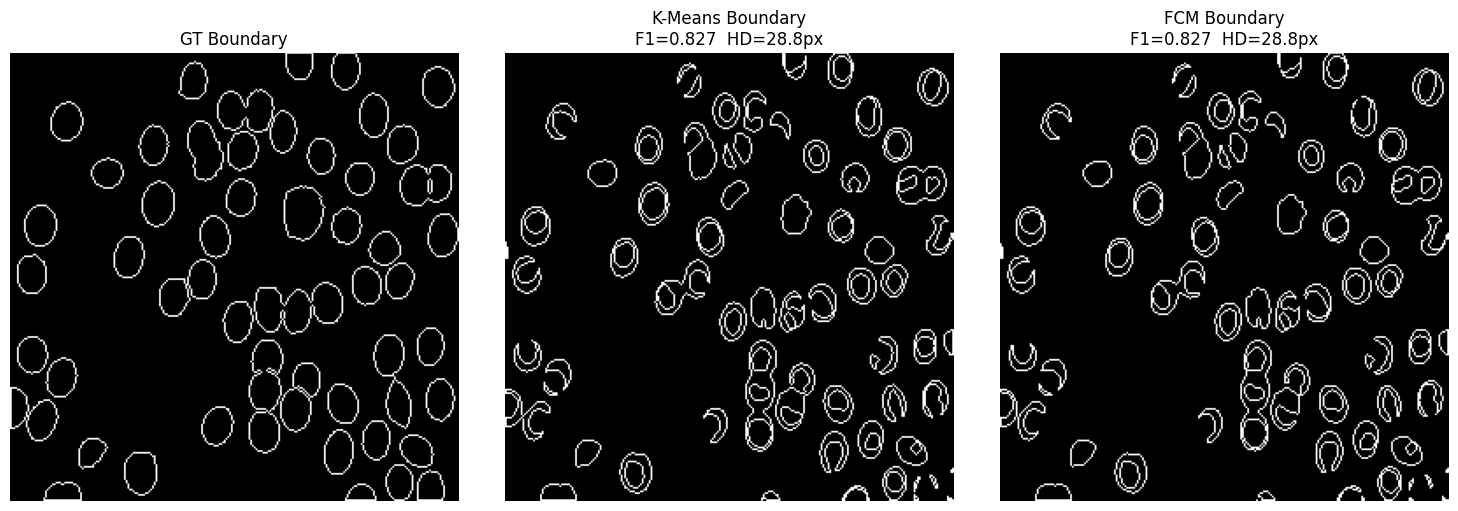

In [15]:

# Boundary Accuracy Evaluation: Hausdorff Distance & Boundary F1-Score
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def extract_boundary(mask):
    """Extract boundary pixels by subtracting eroded mask from original."""
    eroded = binary_erosion(mask)
    boundary = mask.astype(bool) & ~eroded
    return boundary.astype(np.uint8)

def hausdorff_distance(mask1, mask2):
    """Compute symmetric Hausdorff distance between two binary masks."""
    pts1 = np.argwhere(mask1)
    pts2 = np.argwhere(mask2)
    if len(pts1) == 0 or len(pts2) == 0:
        return float('inf')
    d1 = directed_hausdorff(pts1, pts2)[0]
    d2 = directed_hausdorff(pts2, pts1)[0]
    return max(d1, d2)

def boundary_f1_score(pred_boundary, gt_boundary, tolerance=2):
    """
    Compute Boundary F1-Score with a tolerance (in pixels).
    A predicted boundary pixel is a True Positive if it falls within
    'tolerance' pixels of any GT boundary pixel (and vice versa).
    """
    from scipy.ndimage import binary_dilation
    struct = np.ones((2*tolerance+1, 2*tolerance+1))
    
    gt_dilated   = binary_dilation(gt_boundary,   structure=struct)
    pred_dilated = binary_dilation(pred_boundary, structure=struct)
    
    tp_pred = np.sum(pred_boundary & gt_dilated)
    tp_gt   = np.sum(gt_boundary   & pred_dilated)
    
    precision = tp_pred / (np.sum(pred_boundary) + 1e-8)
    recall    = tp_gt   / (np.sum(gt_boundary)   + 1e-8)
    
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

# Extract boundaries
gt_boundary   = extract_boundary(gt_mask)
km_boundary   = extract_boundary(nucleus_mask_kmeans)
fcm_boundary  = extract_boundary(nucleus_mask_fcm)

# --- Hausdorff Distance ---
hd_kmeans = hausdorff_distance(km_boundary, gt_boundary)
hd_fcm    = hausdorff_distance(fcm_boundary, gt_boundary)

print("=== Hausdorff Distance (lower is better) ===")
print(f"K-Means  Hausdorff Distance : {hd_kmeans:.4f} px")
print(f"FCM      Hausdorff Distance : {hd_fcm:.4f} px")

# --- Boundary F1-Score ---
prec_km, rec_km, f1_km   = boundary_f1_score(km_boundary, gt_boundary)
prec_fcm, rec_fcm, f1_fcm = boundary_f1_score(fcm_boundary, gt_boundary)

print("\n=== Boundary F1-Score (higher is better) ===")
print(f"K-Means  | Precision: {prec_km:.4f}  Recall: {rec_km:.4f}  F1: {f1_km:.4f}")
print(f"FCM      | Precision: {prec_fcm:.4f}  Recall: {rec_fcm:.4f}  F1: {f1_fcm:.4f}")

# --- Summary Table ---
print("\n Full Comparison Summary ")
print(f"{'Metric':<30} {'K-Means':>12} {'FCM':>12}")
print("-" * 54)
print(f"{'IoU Score':<30} {iou_kmeans:>12.4f} {iou_fcm:>12.4f}")
print(f"{'Hausdorff Distance (px)':<30} {hd_kmeans:>12.4f} {hd_fcm:>12.4f}")
print(f"{'Boundary Precision':<30} {prec_km:>12.4f} {prec_fcm:>12.4f}")
print(f"{'Boundary Recall':<30} {rec_km:>12.4f} {rec_fcm:>12.4f}")
print(f"{'Boundary F1-Score':<30} {f1_km:>12.4f} {f1_fcm:>12.4f}")

# --- Visualise boundaries ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gt_boundary, cmap='gray');  axes[0].set_title("GT Boundary")
axes[1].imshow(km_boundary,  cmap='gray');  axes[1].set_title(f"K-Means Boundary\nF1={f1_km:.3f}  HD={hd_kmeans:.1f}px")
axes[2].imshow(fcm_boundary, cmap='gray');  axes[2].set_title(f"FCM Boundary\nF1={f1_fcm:.3f}  HD={hd_fcm:.1f}px")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()
